In [1]:
from block_bootstrap_simulation_1v import run_bootstrap_simulation_single
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../data/processed/tmax2m_sp_point.csv", parse_dates=["date"])
data = data.set_index("date")

y = data['tmax2m'].values
y = y - np.nanmean(y)

n = len(y)
autocorr = np.array([np.corrcoef(y[:-lag], y[lag:])[0,1] for lag in range(1, n//2)])

weights = 1 - np.arange(1, len(autocorr)+1) / len(autocorr)
T0 = 1 + 2 * np.sum(weights * autocorr)

print("T0 (en días):", T0)

block_size = int(np.ceil(T0))
print("Tamaño de bloque sugerido (días):", block_size)

T0 (en días): 2.1859190434837874
Tamaño de bloque sugerido (días): 3


In [3]:
n_simulations = 10000
window_days = 10
results_dir = '../data/processed/bootstrap_tmax2m/'
block_size = block_size

run_bootstrap_simulation_single(
    data=data,
    variable="tmax2m",
    n_simulations=n_simulations,
    block_length=block_size,
    window_days=window_days,
    output_dir=results_dir
)

100%|██████████| 10000/10000 [00:10<00:00, 917.37it/s]


✅ Completed 10000 simulations for tmax2m


In [4]:
aep_temp = pd.read_csv(f'{results_dir}aep_curve_tmax2m.csv')
sim_daily_temp = pd.read_csv(f'{results_dir}daily_simulations_tmax2m.csv')
summary_stats = pd.read_csv(f'{results_dir}summary_stats_tmax2m.csv')


Text(0.5, 0, 'Día')

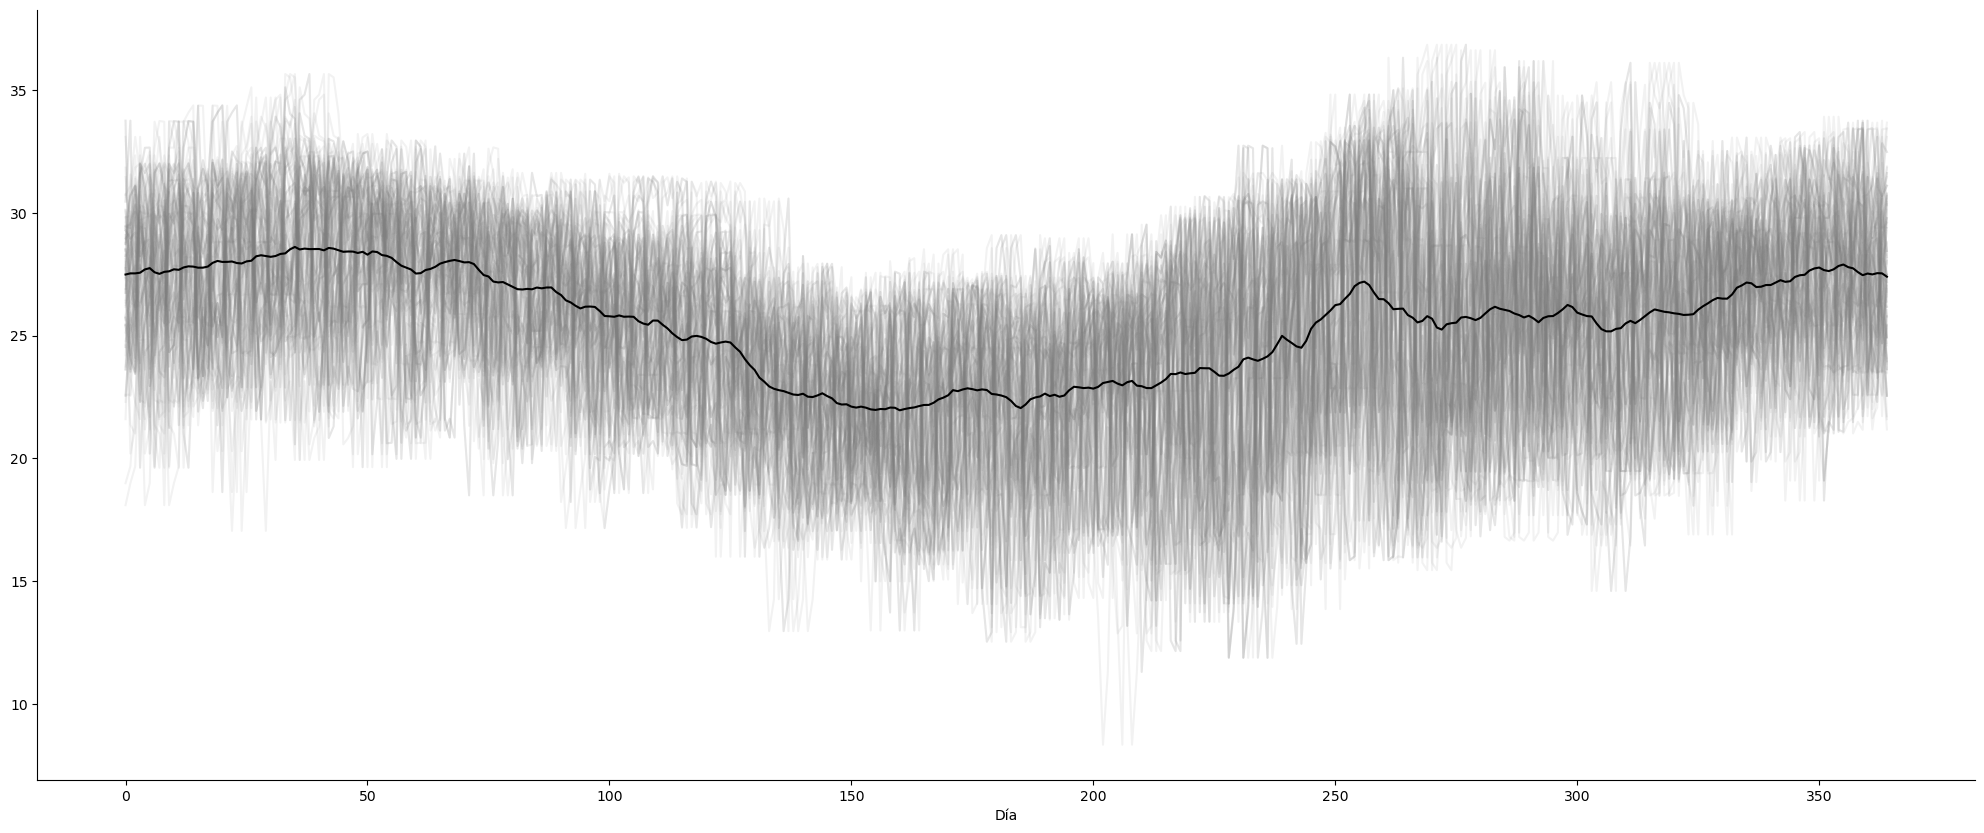

In [22]:
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(sim_daily_temp.iloc[:, 0:100], alpha=0.1, color='gray')
ax.plot(sim_daily_temp.mean(axis=1), alpha=1, color='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Día')

In [5]:
n_sims = len([col for col in sim_daily_temp.columns if col.startswith('sim_')])

sim_dfs = []

for i in range(n_sims):
    sim_num = f'{i:04d}'
    temp_col = f'sim_{sim_num}'
    sim_data = pd.DataFrame({
        'temperature': sim_daily_temp[temp_col]
    })
    sim_data['simulation'] = i
    sim_dfs.append(sim_data)

sim_df_reshaped = pd.concat(sim_dfs, axis=0).reset_index(drop=True)


/var/folders/8j/y_l8frxs2n19mq92k5pv4y100000gn/T/ipykernel_41118/3010341235.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax2.boxplot(data_for_box, labels=['Observadas', 'Sintéticas'], patch_artist=True)


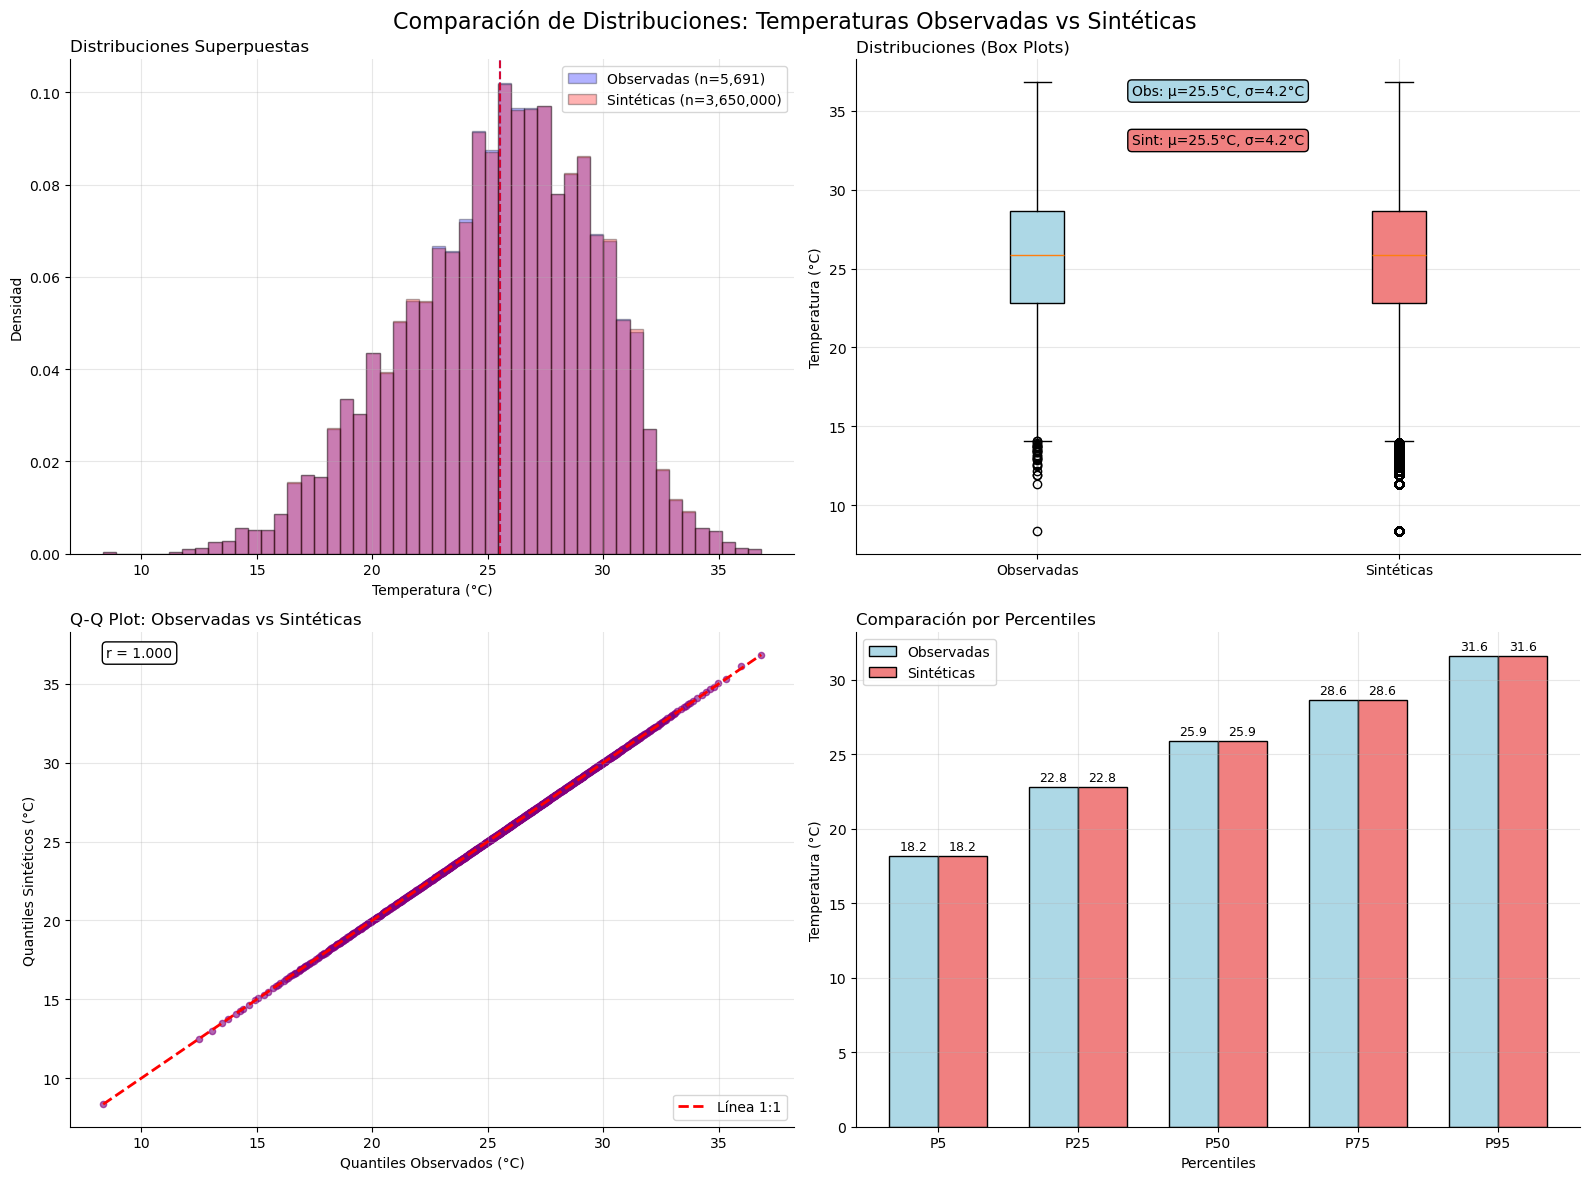

ESTADÍSTICAS COMPARATIVAS
TEMPERATURAS OBSERVADAS:
  N: 5,691
  Media: 25.53°C
  Mediana: 25.89°C
  Desv. Estándar: 4.16°C
  Rango: 8.3°C - 36.8°C

TEMPERATURAS SINTÉTICAS:
  N: 3,650,000 (10000 simulaciones)
  Media: 25.54°C
  Mediana: 25.89°C
  Desv. Estándar: 4.16°C
  Rango: 8.3°C - 36.8°C

COMPARACIÓN:
  Diferencia en media: +0.00°C
  Diferencia en desv. estándar: +0.01°C
  Test K-S: estadístico = 0.0010, p-valor = 1.00e+00

PERCENTILES CRÍTICOS:
  P90.0: Obs=30.6°C, Sint=30.6°C, Diff=+0.0°C
  P95.0: Obs=31.6°C, Sint=31.6°C, Diff=+0.0°C
  P99.0: Obs=33.8°C, Sint=33.8°C, Diff=+0.1°C
  P99.9: Obs=36.0°C, Sint=36.1°C, Diff=+0.1°C


In [6]:
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparación de Distribuciones: Temperaturas Observadas vs Sintéticas', fontsize=16)

observed_temps = data['tmax2m'].values
synthetic_temps = sim_df_reshaped['temperature'].values

# 1. Histograma superpuesto
ax1 = axes[0, 0]
ax1.hist(observed_temps, bins=50, alpha=0.3, density=True, color='blue', 
         label=f'Observadas (n={len(observed_temps):,})', edgecolor='black')

ax1.hist(synthetic_temps, bins=50, alpha=0.3, density=True, color='red', 
         label=f'Sintéticas (n={len(synthetic_temps):,})', edgecolor='black')

ax1.set_xlabel('Temperatura (°C)')
ax1.set_ylabel('Densidad')
ax1.set_title('Distribuciones Superpuestas', loc='left')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Agregar líneas de estadísticas
ax1.axvline(np.mean(observed_temps), color='blue', linestyle='--', alpha=0.8, 
           label=f'Media Obs: {np.mean(observed_temps):.1f}°C')
ax1.axvline(np.mean(synthetic_temps), color='red', linestyle='--', alpha=0.8, 
           label=f'Media Sint: {np.mean(synthetic_temps):.1f}°C')

# 2. Box plots comparativos
ax2 = axes[0, 1]
data_for_box = [observed_temps, synthetic_temps]
box_plot = ax2.boxplot(data_for_box, labels=['Observadas', 'Sintéticas'], patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightblue')
box_plot['boxes'][1].set_facecolor('lightcoral')
ax2.set_ylabel('Temperatura (°C)')
ax2.set_title('Distribuciones (Box Plots)', loc='left')
ax2.grid(True, alpha=0.3)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Agregar estadísticas al box plot
ax2.text(0.5, 0.95, f'Obs: μ={np.mean(observed_temps):.1f}°C, σ={np.std(observed_temps):.1f}°C', 
         transform=ax2.transAxes, ha='center', va='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
ax2.text(0.5, 0.85, f'Sint: μ={np.mean(synthetic_temps):.1f}°C, σ={np.std(synthetic_temps):.1f}°C', 
         transform=ax2.transAxes, ha='center', va='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))

# 3. Q-Q Plot
from scipy import stats
ax3 = axes[1, 0]

# Crear quantiles para comparación
n_quantiles = 1000
obs_quantiles = np.percentile(observed_temps, np.linspace(0, 100, n_quantiles))
syn_quantiles = np.percentile(synthetic_temps, np.linspace(0, 100, n_quantiles))

ax3.scatter(obs_quantiles, syn_quantiles, alpha=0.6, s=20, color='purple')
# Línea 1:1
min_temp = min(obs_quantiles.min(), syn_quantiles.min())
max_temp = max(obs_quantiles.max(), syn_quantiles.max())
ax3.plot([min_temp, max_temp], [min_temp, max_temp], 'r--', linewidth=2, label='Línea 1:1')
ax3.set_xlabel('Quantiles Observados (°C)')
ax3.set_ylabel('Quantiles Sintéticos (°C)')
ax3.set_title('Q-Q Plot: Observadas vs Sintéticas', loc='left')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Calcular correlación de quantiles
quantile_corr = np.corrcoef(obs_quantiles, syn_quantiles)[0, 1]
ax3.text(0.05, 0.95, f'r = {quantile_corr:.3f}', transform=ax3.transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white"))

# 4. Distribuciones por percentiles
ax4 = axes[1, 1]
percentiles = [5, 25, 50, 75, 95]
obs_percs = [np.percentile(observed_temps, p) for p in percentiles]
syn_percs = [np.percentile(synthetic_temps, p) for p in percentiles]

x = np.arange(len(percentiles))
width = 0.35
ax4.bar(x - width/2, obs_percs, width, label='Observadas', color='lightblue', edgecolor='black')
ax4.bar(x + width/2, syn_percs, width, label='Sintéticas', color='lightcoral', edgecolor='black')
ax4.set_xlabel('Percentiles')
ax4.set_ylabel('Temperatura (°C)')
ax4.set_title('Comparación por Percentiles', loc='left')
ax4.set_xticks(x)
ax4.set_xticklabels([f'P{p}' for p in percentiles])
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

# Agregar valores encima de las barras
for i, (obs_val, syn_val) in enumerate(zip(obs_percs, syn_percs)):
    ax4.text(i - width/2, obs_val + 0.2, f'{obs_val:.1f}', ha='center', va='bottom', fontsize=9)
    ax4.text(i + width/2, syn_val + 0.2, f'{syn_val:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Estadísticas de comparación
print("=" * 60)
print("ESTADÍSTICAS COMPARATIVAS")
print("=" * 60)

print(f"TEMPERATURAS OBSERVADAS:")
print(f"  N: {len(observed_temps):,}")
print(f"  Media: {np.mean(observed_temps):.2f}°C")
print(f"  Mediana: {np.median(observed_temps):.2f}°C")
print(f"  Desv. Estándar: {np.std(observed_temps):.2f}°C")
print(f"  Rango: {np.min(observed_temps):.1f}°C - {np.max(observed_temps):.1f}°C")

print(f"\nTEMPERATURAS SINTÉTICAS:")
print(f"  N: {len(synthetic_temps):,} ({len(sim_df_reshaped['simulation'].unique())} simulaciones)")
print(f"  Media: {np.mean(synthetic_temps):.2f}°C")
print(f"  Mediana: {np.median(synthetic_temps):.2f}°C")
print(f"  Desv. Estándar: {np.std(synthetic_temps):.2f}°C")
print(f"  Rango: {np.min(synthetic_temps):.1f}°C - {np.max(synthetic_temps):.1f}°C")

print(f"\nCOMPARACIÓN:")
diff_mean = np.mean(synthetic_temps) - np.mean(observed_temps)
diff_std = np.std(synthetic_temps) - np.std(observed_temps)
print(f"  Diferencia en media: {diff_mean:+.2f}°C")
print(f"  Diferencia en desv. estándar: {diff_std:+.2f}°C")

# Test de Kolmogorov-Smirnov
ks_stat, ks_pvalue = stats.ks_2samp(observed_temps, synthetic_temps)
print(f"  Test K-S: estadístico = {ks_stat:.4f}, p-valor = {ks_pvalue:.2e}")

print(f"\nPERCENTILES CRÍTICOS:")
critical_percentiles = [90, 95, 99, 99.9]
for p in critical_percentiles:
    obs_p = np.percentile(observed_temps, p)
    syn_p = np.percentile(synthetic_temps, p)
    diff_p = syn_p - obs_p
    print(f"  P{p:4.1f}: Obs={obs_p:.1f}°C, Sint={syn_p:.1f}°C, Diff={diff_p:+.1f}°C")

In [8]:
# fraction_brave_riders = 0.6
# fraction_hw_wage = 3

# total_riders = 20000
# normal_wage = 1

# brave_riders = int(total_riders * fraction_brave_riders)
# no_brave_riders = total_riders - brave_riders

# hw_wage = normal_wage * fraction_hw_wage

# daily_loss = np.abs(total_riders * normal_wage - (brave_riders * hw_wage))

daily_loss = 200000 #  n_riders * daily_compensation = 20k * 10 usd = 200000 usd



Análisis para umbral de temperatura: 32.5°C
Porcentaje de días con evento: 2.6721

Promedio de eventos y pérdidas anuales por simulación:
             Media   Mediana   Máximo  Mínimo
event       2.6721       3.0       17       0
loss   534420.0000  600000.0  3400000       0

Análisis para umbral de temperatura: 33.5°C
Porcentaje de días con evento: 1.0908

Promedio de eventos y pérdidas anuales por simulación:
             Media  Mediana   Máximo  Mínimo
event       1.0908      0.0       13       0
loss   218160.0000      0.0  2600000       0

Análisis para umbral de temperatura: 34.5°C
Porcentaje de días con evento: 0.3540

Promedio de eventos y pérdidas anuales por simulación:
           Media  Mediana   Máximo  Mínimo
event      0.354      0.0        9       0
loss   70800.000      0.0  1800000       0

Análisis para umbral de temperatura: 35.5°C
Porcentaje de días con evento: 0.0791

Promedio de eventos y pérdidas anuales por simulación:
            Media  Mediana   Máximo  Mínim

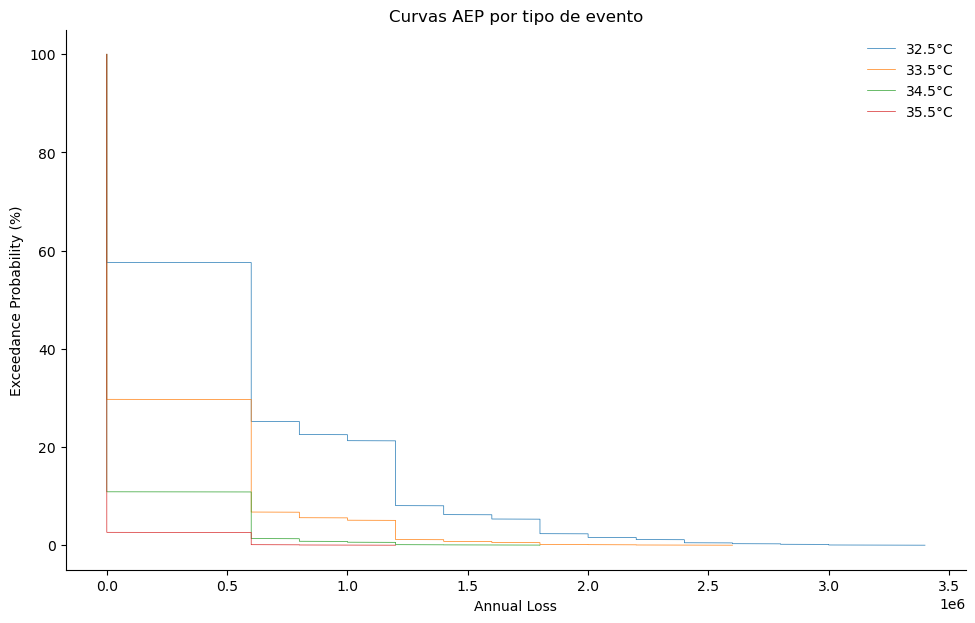

In [25]:

thresholds = [32.5, 33.5, 34.5, 35.5]

fig = plt.figure(figsize=(10,6))
ax = plt.axes([0.05, 0.05, 0.9, 0.9])


for i, threshold in enumerate(thresholds):
    print(f"\nAnálisis para umbral de temperatura: {threshold}°C")

    threshold_temperature = threshold

    sim_df_reshaped['cond_temp'] = (sim_df_reshaped['temperature'] > threshold_temperature).astype(int)

    def _mark_runs(series, min_len=3):
        cond = series.astype(bool)
        runs = (cond != cond.shift()).cumsum()
        run_sizes = cond.groupby(runs).transform('size')
        return ((cond) & (run_sizes >= min_len)).astype(int)

    sim_df_reshaped['event'] = sim_df_reshaped.groupby('simulation', group_keys=False)['cond_temp'].apply(_mark_runs)
    sim_df_reshaped['loss'] = daily_loss * sim_df_reshaped['event']

    total_dias = len(sim_df_reshaped)

    frac_event = sim_df_reshaped['event'].sum() / n_sims

    print(f"Porcentaje de días con evento: {frac_event:.4f}")

    # sim_df_reshaped['day_of_year'] = np.tile(np.arange(1, 366), len(sim_df_reshaped['simulation'].unique()))

    # summer_days = list(range(305, 366)) + list(range(1, 91))
    # sim_df_summer = sim_df_reshaped[sim_df_reshaped['day_of_year'].isin(summer_days)].copy()

    # sim_df_summer['cond_temp_summer'] = (sim_df_summer['temperature'] > threshold_temperature).astype(int)
    # sim_df_summer['event_summer'] = sim_df_summer.groupby('simulation', group_keys=False)['cond_temp_summer'].apply(_mark_runs)
    # sim_df_summer['loss_summer'] = daily_loss * sim_df_summer['event_summer']

    # total_days_summer = len(sim_df_summer)
    # frac_event_summer = sim_df_summer['event_summer'].sum() / total_days_summer
    # print(f"Porcentaje de días con evento (verano): {frac_event_summer:.2%}")

    summary_by_sim = sim_df_reshaped.groupby('simulation').agg({
        'event': 'sum',
        'loss': 'sum'
    })

    summary_stats = summary_by_sim.mean().to_frame("Media")
    summary_stats["Mediana"] = summary_by_sim.median()
    summary_stats["Máximo"] = summary_by_sim.max()
    summary_stats["Mínimo"] = summary_by_sim.min()

    print("\nPromedio de eventos y pérdidas anuales por simulación:")
    print(summary_stats)

    def build_aep(loss_series, label):
        s = loss_series.sort_values(ascending=False).reset_index(drop=True)
        n = len(s)
        ex_prob = [(i)/(n+1)*100 for i in range(1, n+1)]    # 100/(n+1) es la probabilidad de excedencia
        return pd.DataFrame({'Loss': s, 'Exceedance_Probability': ex_prob, 'Type': label})

    aep_temp = build_aep(summary_by_sim['loss'], 'event')


    ax.plot(aep_temp['Loss'], aep_temp['Exceedance_Probability'], label="{}°C".format(threshold), lw=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel('Exceedance Probability (%)')
    ax.set_xlabel('Annual Loss')
    ax.set_title('Curvas AEP por tipo de evento')
    ax.legend(frameon=False)

